# TEST RESULT

In [2]:
from pathlib import Path
import json
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('/workspace/detect-me/product_classifier/scripts/utils/')
import utils

In [3]:
category = 'sausages'

In [4]:
BASE = Path(f'/workspace/detect-me/product_classifier/saved_models/') /category

!ls $BASE

densenet201  inception_resnet_v2  tensorboard_logs  test_result


In [5]:
list_modes = ['densenet121',
'efficientnetb7',
'resnet152v2',
'resnet50v2',
'densenet201',
'inception_resnet_v2',
'resnet50',
'vgg16',
]

test_results = (BASE / 'test_result').glob('*.json')
data_dict = dict() 
for filep in test_results:
    with open(filep) as file:
        data = json.load(file)
    data_dict[filep.stem] = data

dataframe_testResult = pd.DataFrame(data_dict).T.reset_index()
dataframe_testResult = \
        dataframe_testResult.rename({'index' : 'tag'},
                            axis=1)

In [6]:
patterns = [('freeze', '(?<=Freeze-)\d+'),
           ('lr' , '(?<=lr-)[\d|.]+'),
           ('dropout' , '(?<=dropout-)[\d|.]+'),
           ('epochs_it_ran' , '(?<=epochs_it_ran-)\d+'),
           ('tag_HMS' , '(?<=----)\d+'),
           ('modelname' , '(\w+)-{3}'),
           ('date' , '(?<=__).*?(?=----)')
           ]

for (n , p) in patterns:
    if n == 'modelname':
        group = 1
    else:
        group=0
    dataframe_testResult.loc[:,n] =\
        dataframe_testResult['tag'].\
                apply(lambda x : re.search(p,x).group(group) if re.search(p,x) else np.nan)


dataframe_testResult = dataframe_testResult.assign(
        f1_score = ((2*dataframe_testResult['recall-tr--0.9']*dataframe_testResult['PRCN-tr-0.9'])/
                        (dataframe_testResult['recall-tr--0.9'] + dataframe_testResult['PRCN-tr-0.9'])))

In [7]:
dataframe_testResult

,tag,loss,accuracy,top_3_acc,PRCN-tr-0.5,PRCN-tr-0.9,recall-tr--0.5,recall-tr--0.9,length_classes,freeze,lr,dropout,epochs_it_ran,tag_HMS,modelname,date,f1_score
0,DenseNet201---(Freeze-40)-(lr-0.002-adam)-(epo...,4.039377,0.0,0.00,0.0,0.0,0.0,0.00,NaN,40,0.002,0.0,15,103632,DenseNet201,2021-Oct-02,NaN
1,INCEPTION_RES---(Freeze-400)-(lr-0.008-adam)-(...,2.615596,0.0,1.00,0.0,0.0,0.0,0.00,548.0,400,0.008,0.0,25,172156,INCEPTION_RES,2021-Oct-10,NaN
2,DenseNet201---(Freeze-40)-(lr-0.002-adam)-(epo...,4.147653,0.5,0.50,0.0,0.0,0.0,0.00,548.0,40,0.002,0.0,24,173122,DenseNet201,2021-Oct-10,NaN
3,INCEPTION_RES---(Freeze-0)-(lr-0.004-adam)-(ep...,2.016898,0.5,0.75,0.5,1.0,0.5,0.25,58.0,0,0.004,0.0,17,094327,INCEPTION_RES,2021-Oct-23,0.4


In [8]:
def plot_rel(col):
    sns.set_theme(style="whitegrid", palette="pastel")
    # cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    with sns.plotting_context(rc={"legend.fontsize":15,
                                 'legend.title_fontsize' : 18}):
        g = sns.relplot(
            data=dataframe_testResult,
            x="modelname",
            y=col,
            hue="modelname",
            s=500,
    #         size="dropout",
            height=6, aspect=2.4, alpha=0.8,
    #         sizes=,
        )
        # g.set(xscale="log", yscale="log")
        g.ax.xaxis.grid(True, "minor", linewidth=.25)
        g.ax.yaxis.grid(True, "minor", linewidth=.25)
        g.ax.set_xlabel('')
        g.ax.set_ylabel(col, rotation=90, fontsize=15,)
    #     plt.xticks(rotation = 90)
        g.ax.set_xticklabels(g.ax.get_xticklabels() , rotation=90 ) 
        g.despine(left=True, bottom=True)
#         g.savefig("output.png",quality=100)
    return g

<ipython-input-8-d10f0dac2f7b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels(g.ax.get_xticklabels() , rotation=90 )


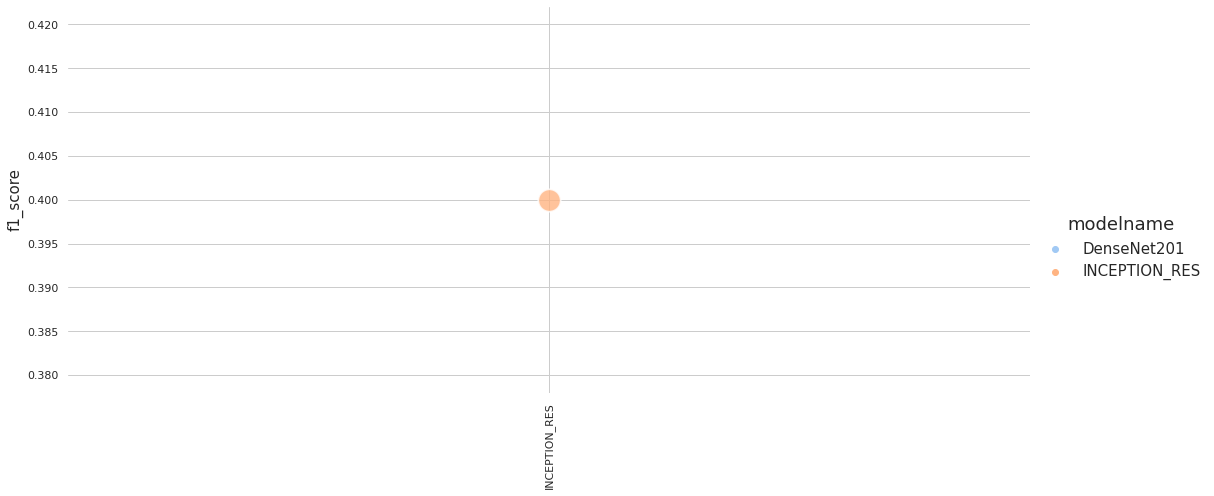

In [9]:
pp = plot_rel('f1_score')

<ipython-input-8-d10f0dac2f7b>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.ax.set_xticklabels(g.ax.get_xticklabels() , rotation=90 )


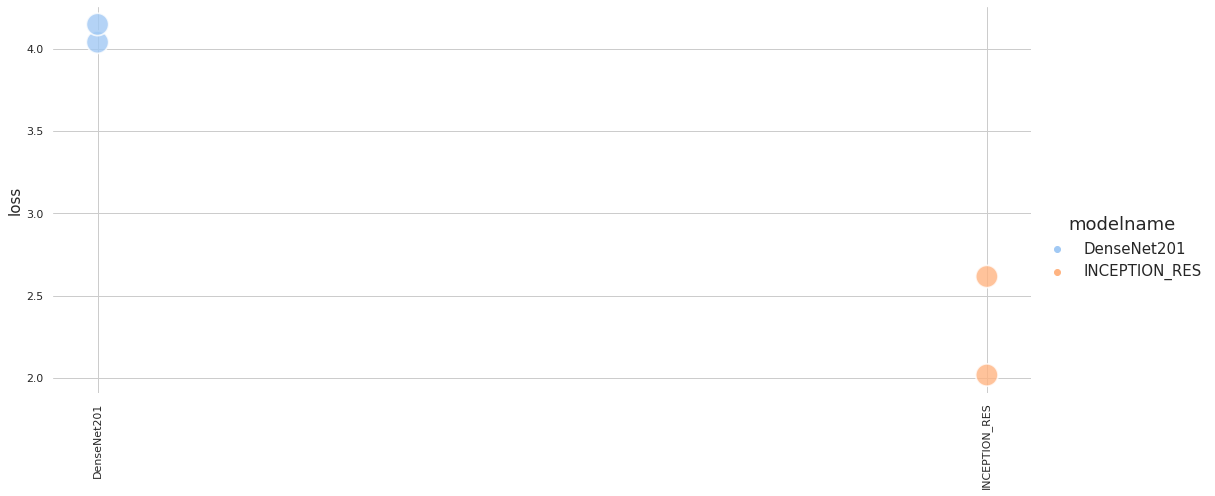

In [10]:
plot_rel('loss')

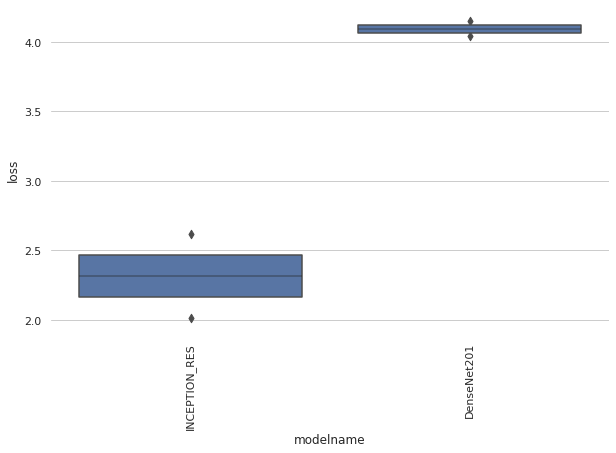

In [11]:
orders = dataframe_testResult.groupby('modelname').loss.min().sort_values(ascending=True).index.values

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10,6))
ax = sns.boxenplot(x="modelname", y="loss",
              color="b", order=orders,
              scale="linear",
              data=dataframe_testResult)
ax.set_xticklabels(ax.get_xticklabels() , rotation=90 ) 
sns.despine(left=True, bottom=True)

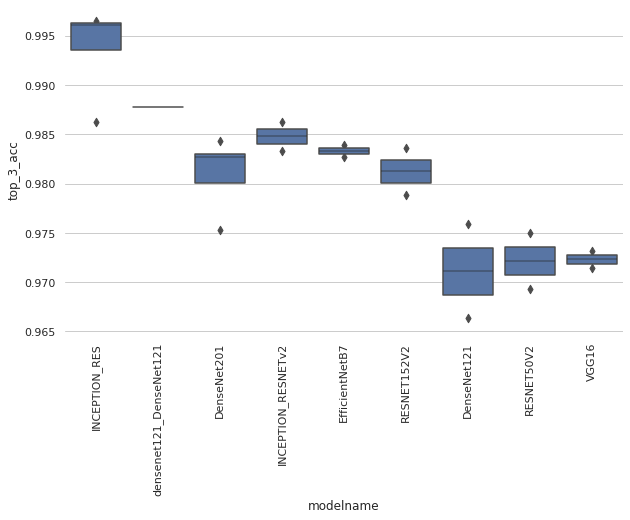

In [11]:
plt.figure(figsize=(10,6))
ax = sns.boxenplot(x="modelname", y="top_3_acc",
              color="b", order=orders,
              scale="linear",
              data=dataframe_testResult)
ax.set_xticklabels(ax.get_xticklabels() , rotation=90 ) 
sns.despine(left=True, bottom=True)

In [12]:
dataframe_testResult.sort_values('PRCN-tr-0.9')

,tag,loss,accuracy,top_3_acc,PRCN-tr-0.5,PRCN-tr-0.9,recall-tr--0.5,recall-tr--0.9,top_3_accuracy,length_classes,freeze,lr,dropout,epochs_it_ran,tag_HMS,modelname,date,f1_score
11,INCEPTION_RES---(Freeze-200)-(lr-0.0044-adam)-...,0.236832,0.937500,0.986310,0.949452,0.977941,0.927976,0.870833,NaN,NaN,200,0.0044,0.0,NaN,164556,INCEPTION_RES,2021-Aug-19,0.921285
13,RESNET50V2---(Freeze-0)-(lr-0.001-adam)-(opt_c...,0.331798,0.913988,0.969345,0.938160,0.981400,0.898512,0.800893,NaN,NaN,0,0.001,0.0,NaN,113334,RESNET50V2,2021-Aug-20,0.882006
10,EfficientNetB7---(Freeze-20)-(lr-0.0044-adam)-...,0.236151,0.940476,0.983929,0.951530,0.982006,0.934821,0.877083,NaN,NaN,20,0.0044,0.3,NaN,005404,EfficientNetB7,2021-Aug-19,0.926584
9,DenseNet201---(Freeze-0)-(lr-0.001-adam)-(opt_...,0.216933,0.944940,0.982738,0.956127,0.982428,0.940476,0.898512,NaN,NaN,0,0.001,0.4,NaN,142849,DenseNet201,2021-Aug-18,0.938598
3,DenseNet201---(Freeze-200)-(lr-0.001-adam)-(op...,0.228099,0.938095,NaN,0.949394,0.983645,0.932440,0.877083,0.983333,NaN,200,0.001,0.0,NaN,152748,DenseNet201,2021-Aug-17,0.927313
17,RESNET152V2---(Freeze-500)-(lr-0.0004-adam)-(o...,0.236713,0.943155,0.983631,0.953799,0.984011,0.933929,0.879167,NaN,NaN,500,0.0004,0.4,18,043202,RESNET152V2,2021-Aug-21,0.928639
14,RESNET50V2---(Freeze-0)-(lr-0.0001-adam)-(opt_...,0.288796,0.925000,0.975000,0.941843,0.984061,0.915774,0.845238,NaN,NaN,0,0.0001,0.0,NaN,130216,RESNET50V2,2021-Aug-20,0.909382
22,DenseNet121---(Freeze-50)-(lr-0.0008-adam)-(op...,0.322026,0.912798,NaN,0.935564,0.984471,0.898810,0.811310,0.974405,NaN,50,0.0008,0.0,NaN,031046,DenseNet121,2021-Aug-17,0.889542
5,VGG16---(Freeze-7)-(lr-0.0001-adam)-(opt_cb-co...,0.329461,0.908631,0.971429,0.934661,0.984473,0.894048,0.792560,NaN,NaN,7,0.0001,0.0,NaN,214816,VGG16,2021-Aug-17,0.878153
7,DenseNet201---(Freeze-400)-(lr-0.002-adam)-(op...,0.257322,0.933631,0.980060,0.955686,0.984706,0.917857,0.843155,NaN,NaN,400,0.002,0.2,NaN,033413,DenseNet201,2021-Aug-18,0.908450


In [13]:
sorted_recall = dataframe_testResult.sort_values(['recall-tr--0.9', 'PRCN-tr-0.9' ], ascending=False)
tag = sorted_recall.head(1)['tag_HMS'].item()
mname = sorted_recall.head(1)['modelname'].item()

In [14]:
def get_best_classifier(path_to_test_result:str,
                        metric=None):
    test_results = (path_to_test_result / 'test_result').glob('*.json')
    data_dict = dict() 
    for filep in test_results:
        with open(filep) as file:
            data = json.load(file)
        data_dict[filep.stem] = data

    dataframe_testResult = pd.DataFrame(data_dict).T.reset_index()
    dataframe_testResult = \
            dataframe_testResult.rename({'index' : 'tag'},
                                    axis=1)
    patterns = [('freeze', '(?<=Freeze-)\d+'),
               ('lr' , '(?<=lr-)[\d|.]+'),
               ('dropout' , '(?<=dropout-)[\d|.]+'),
               ('epochs_it_ran' , '(?<=epochs_it_ran-)\d+'),
               ('tag_HMS' , '(?<=----)\d+'),
               ('modelname' , '(\w+)-{3}'),
               ('date' , '(?<=__).*?(?=----)')
               ]

    for (n , p) in patterns:
        if n == 'modelname':
            group = 1
        else:
            group=0
        dataframe_testResult.loc[:,n] =\
            dataframe_testResult['tag'].\
                    apply(lambda x : re.search(p,x).group(group) if re.search(p,x) else np.nan)


    dataframe_testResult.head(1)

    prec_at90 = dataframe_testResult['PRCN-tr-0.9']
    recall_at90 = dataframe_testResult['recall-tr--0.9']
    dataframe_testResult = \
        dataframe_testResult.assign(
            f1score = (2*(recall_at90*prec_at90)/
                               (recall_at90+prec_at90)
                      ))
    dataframe_testResult.f1score = dataframe_testResult.f1score.fillna(0)

#     import pdb;pdb.set_trace()
    dataframe_testResult = dataframe_testResult.sort_values(['f1score'], ascending=False)
    
    best_model_baseon_testset = dataframe_testResult.head(1)
    
    tag= best_model_baseon_testset['tag_HMS'].item()
    print('best model')
    print(best_model_baseon_testset)
    root_tree = (path_to_test_result).rglob('*')

    df = pd.DataFrame(root_tree)

    df.columns = ['fullpath']

    df = pd.concat([pd.DataFrame((df['fullpath'].apply(lambda x: x.parts)).to_list()),
              df],axis=1)
#     print(tag)
    model_path = df[(df[8] == 'saved_model.pb') & df[7].str.contains(tag)]['fullpath']

    model_path = model_path.item().parent
    return model_path

In [15]:
cat = 'milk'
root_classifier = Path('/workspace/detect-me/product_classifier/saved_models/')
model_path = get_best_classifier(root_classifier/cat)
# get_best_classifier(model_path)

best model
                                                 tag      loss  accuracy  \
7  INCEPTION_RES---(Freeze-400)-(lr-0.01-adam)-(e...  0.347265  0.920684   

   top_3_acc  PRCN-tr-0.5  PRCN-tr-0.9  recall-tr--0.5  recall-tr--0.9  \
7   0.975117     0.924765     0.974138        0.917574        0.878694   

   length_classes freeze    lr dropout epochs_it_ran tag_HMS      modelname  \
7           362.0    400  0.01     0.0            25  093850  INCEPTION_RES   

          date   f1score  
7  2021-Oct-15  0.923957  


---

---

---

---

## DATA,  let's see 

loading data tree .. .. 
data tree return ed (142439, 7)
preparing dataframe 
<_____________________
(136302, 8)
after removing images from database (DB_)
(78536, 8)
_____________________>
df.first_level == milk
(13802, 8)
before downsample (13802, 8)
after downsample (11796, 8)
                                filepath   class
0    ../data/milk/train-val/256923/0.jpg  256923
1    ../data/milk/train-val/256923/1.jpg  256923
2   ../data/milk/train-val/256923/10.jpg  256923
3  ../data/milk/train-val/256923/108.jpg  256923
4  ../data/milk/train-val/256923/109.jpg  256923
train_validation_df class nunique
362
preparing dataframe 
<_____________________
(6137, 8)
after removing images from database (DB_)
(6136, 8)
_____________________>
df.first_level == milk
(783, 8)
before downsample (783, 8)
after downsample (644, 8)
len classes_set 362
Found 9343 validated image filenames belonging to 362 classes.
Found 2453 validated image filenames belonging to 362 classes.
Found 643 validated image fi

/workspace/keras-retinanet/keras-retina-venv/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


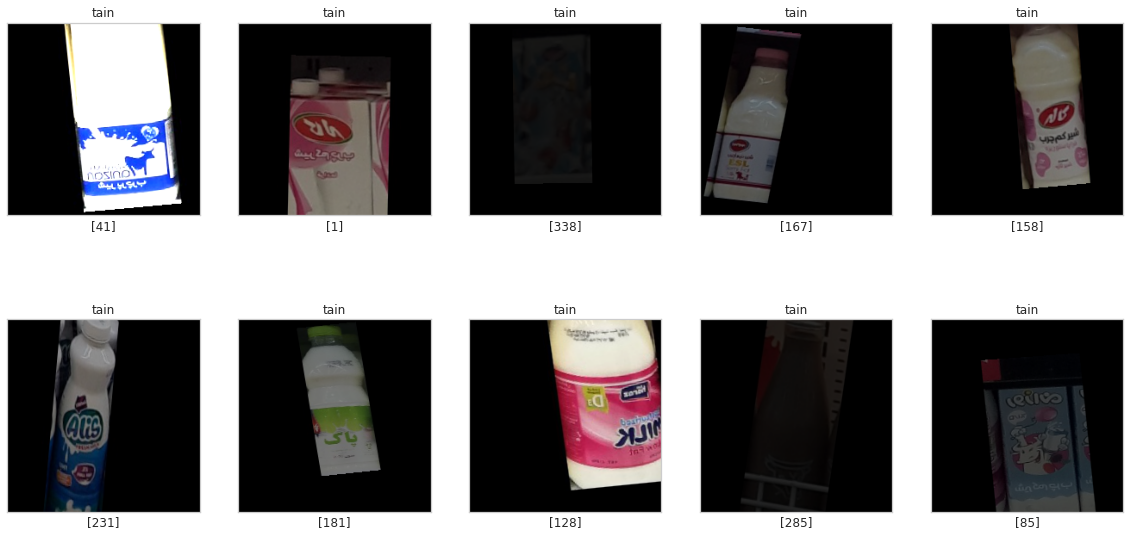

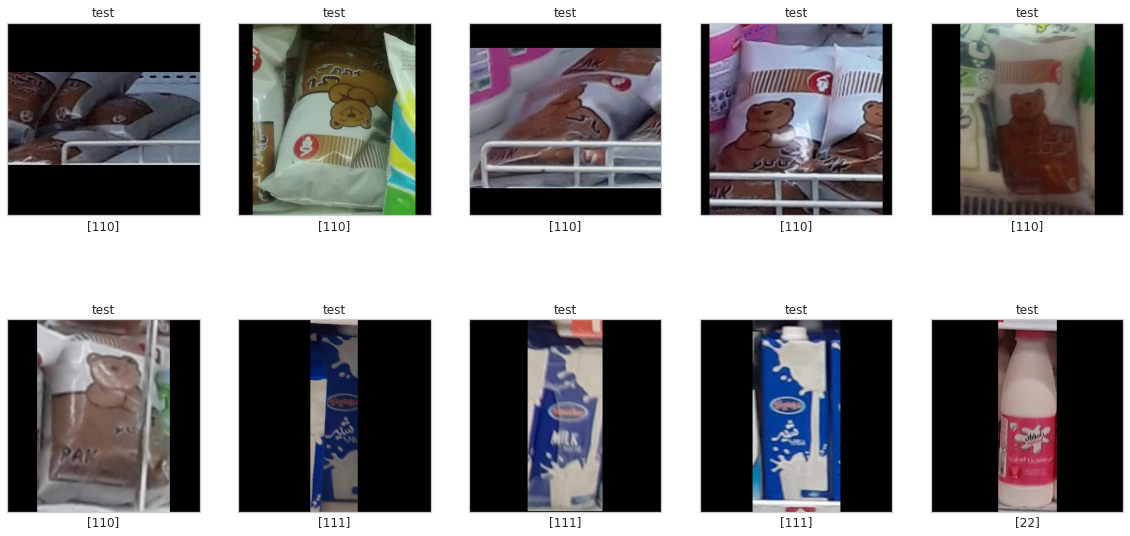

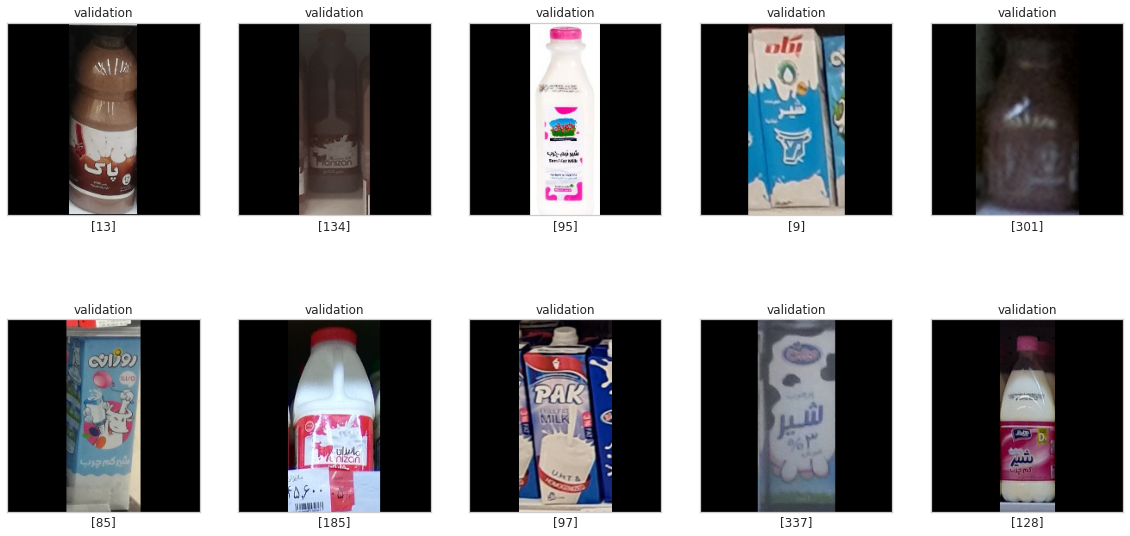

In [15]:
import sys
sys.path.append('../scripts')
from utils.data_loader import load_data_flow_from_dataframe
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn

data_dir = '../data'

data_flow_df = load_data_flow_from_dataframe(
                data_dir,
                (224,224),
                batch_size=1,
                category=category)

def plot_from_flow(flow , howmany, ncols, title=''):
    rows = math.ceil(howmany/ncols)
    plt.figure(figsize=(20,rows*5))
    for i in range(howmany):
        plt.subplot(rows,ncols,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title(title)
        image , label = flow.__next__()
        image = image.astype(np.uint8)
        plt.imshow(image[0,...],
                  )
        plt.xlabel(np.argmax(label, axis=1))
    plt.show()
plot_from_flow(data_flow_df['train'], 10, 5, 'tain')

plot_from_flow(data_flow_df['test'], 10, 5, 'test')

plot_from_flow(data_flow_df['validation'], 10, 5, 'validation')

# evaluate save models 

In [16]:
from tensorflow.keras.models import load_model
import pandas as pd
from pathlib import Path
from itertools import islice

In [17]:
seaborn.set(rc={'axes.facecolor':'#eeeeee', 'figure.facecolor':'#eeeeee'})

In [18]:
BASE = Path(f'/workspace/detect-me/product_classifier/saved_models/{category}/')

!ls $BASE

densenet201  inception_resnet_v2  resnet152v2  tensorboard_logs  test_result


In [22]:
model_name ='resnet152v2'
!ls $BASE/$model_name

'RESNET152V2---(Freeze-0)-(lr-0.0005-adam)-(epoch-50)-(batch-24)-(dropout-0.0)-add_VMS_PREDS__2021-Oct-14----221137'
'RESNET152V2---(Freeze-20)-(lr-0.0008-adam)-(epoch-50)-(batch-24)-(dropout-0.0)-add_VMS_PREDS__2021-Oct-14----183716'
'RESNET152V2---(Freeze-20)-(lr-0.0008-adam)-(epoch-50)-(batch-24)-(dropout-0.0)-add_VMS_PREDS__2021-Oct-15----082624'


In [23]:
tag = '082624'

In [24]:
model_path = list(Path(BASE / 'resnet152v2').glob(f'*{tag}'))[0]

In [25]:
def load_model_with_info(model_path):
    csv = pd.read_csv(model_path/  'label_mapping.csv')
    train_count =\
        pd.read_csv(model_path / 'train_info.csv',
                              index_col=0,
                              names = ['code', 'count'])
    train_count = train_count.reset_index().dropna().drop('index',axis=1)

    joind_train_info = train_count.set_index('code').join(csv.set_index('CODE'))
    joind_train_info.index.name = 'label-code'
    joind_train_info = joind_train_info.reset_index()

    model = load_model(model_path)
    return model ,  joind_train_info

In [27]:
model, train_info = load_model_with_info(model_path)

In [95]:
y_test = data_flow_df['test'].classes
y_train = data_flow_df['train'].classes

counts_train = np.unique(y_train,
                        return_counts=True)
df_train= pd.DataFrame(counts_train).T
df_train.columns = ['label', 'count_in_trainset']
df_train = df_train.set_index('label')


# PREDICT ##
y_pred = model.predict(data_flow_df['test'])
y_pred = np.argmax(y_pred,axis=1)

In [209]:
wrong_preds = pd.DataFrame({'true_label' : np.array(y_test)[y_pred != y_test],
                           'wrong_pred' : y_pred[y_pred != y_test]})
wrong_preds.head(1)

,true_label,wrong_pred
0,108,111


# sklearn confusion_matrix

In [259]:
from sklearn.metrics import confusion_matrix
labels_ = sorted(list(set([*wrong_preds['true_label'],*wrong_preds['wrong_pred']])))
cm = confusion_matrix(wrong_preds['true_label'],
                      wrong_preds['wrong_pred'],
                      labels=labels_
                     )

In [260]:
b=cm.sum(axis=1).reshape(-1,1)
cm_p = np.divide(cm,
              b,
#               out=np.zeros_like(cm),
              where=b!=0
             )

In [261]:
cm_p = np.round(cm_p,3)

In [262]:
annot = np.where(cm_p==0, np.nan, cm_p)

Text(241.5, 0.5, 'true labels')

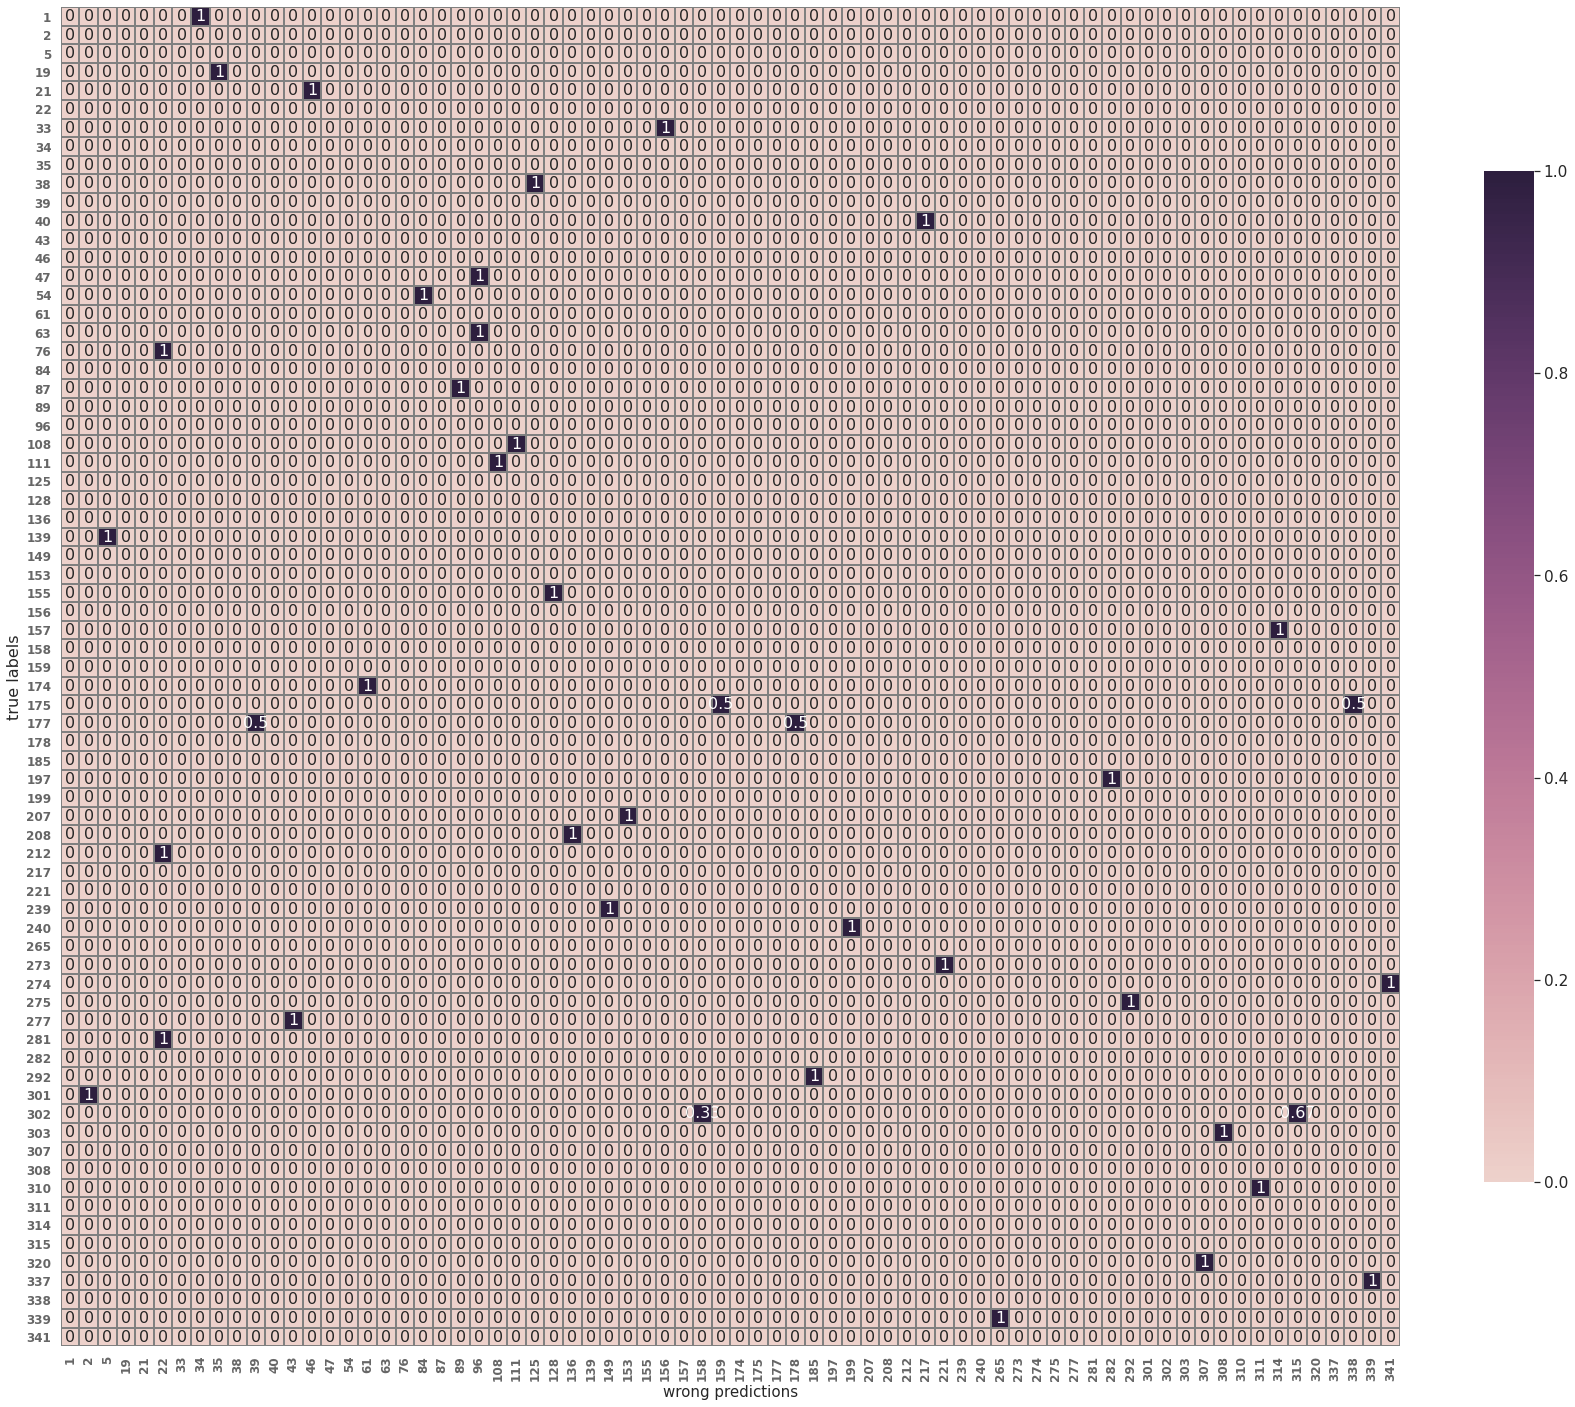

In [270]:
fig , ax = plt.subplots(1,1, figsize=(30,30))
sns.set(font_scale=1.4) # for label size
sns.heatmap(cm,
#             mask=cm_p <= 0,
            annot=cm_p,
            xticklabels = labels_,
            linewidths = 2,
            square=True,
#             cmap="viridis_r",
            cmap=sns.cubehelix_palette(as_cmap=True),
            linecolor='gray',
            vmin= 0,
            vmax=1,
            yticklabels= labels_,
            annot_kws={"size": 16},
            cbar_kws={"shrink": .62},
           ax=ax) # font size
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=90,
              fontsize = 12,
                 color='#666666',
                  fontweight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),
                   rotation=0,
                  fontsize = 12,
                   color='#666666',
                  fontweight = 'bold')
ax.set_xlabel('wrong predictions',
                           fontsize = 15,)
ax.set_ylabel('true labels',
                           fontsize = 16,)

# sklearn classification_report

In [100]:
report = classification_report(y_test,
                               y_pred,
                               zero_division=0,
                              output_dict=True)

report_test = pd.DataFrame(report).T

classes = data_flow_df['train'].classes
classes = [str(x) for x in classes]

report_test = report_test.loc[report_test.index.isin(set(classes))]
report_test.index = report_test.index.astype(int)

train_info = train_info.set_index('label-code')

join_result = report_test.join(df_train).join(train_info)
join_result.head(2)

,precision,recall,f1-score,support,count_in_trainset,count,CLASS
1,1.000000,0.666667,0.8,3.0,80,80,106667
2,0.666667,1.000000,0.8,2.0,48,48,106668


In [118]:
cols = ['CLASS', 'recall', 'f1-score', 'precision', 'support']

In [119]:
harvest = join_result[cols]
# harvest = harvest.set_index('CLASS')
harvest = harvest.sort_values(['recall', 'precision'])
parts = np.array_split(harvest,5)

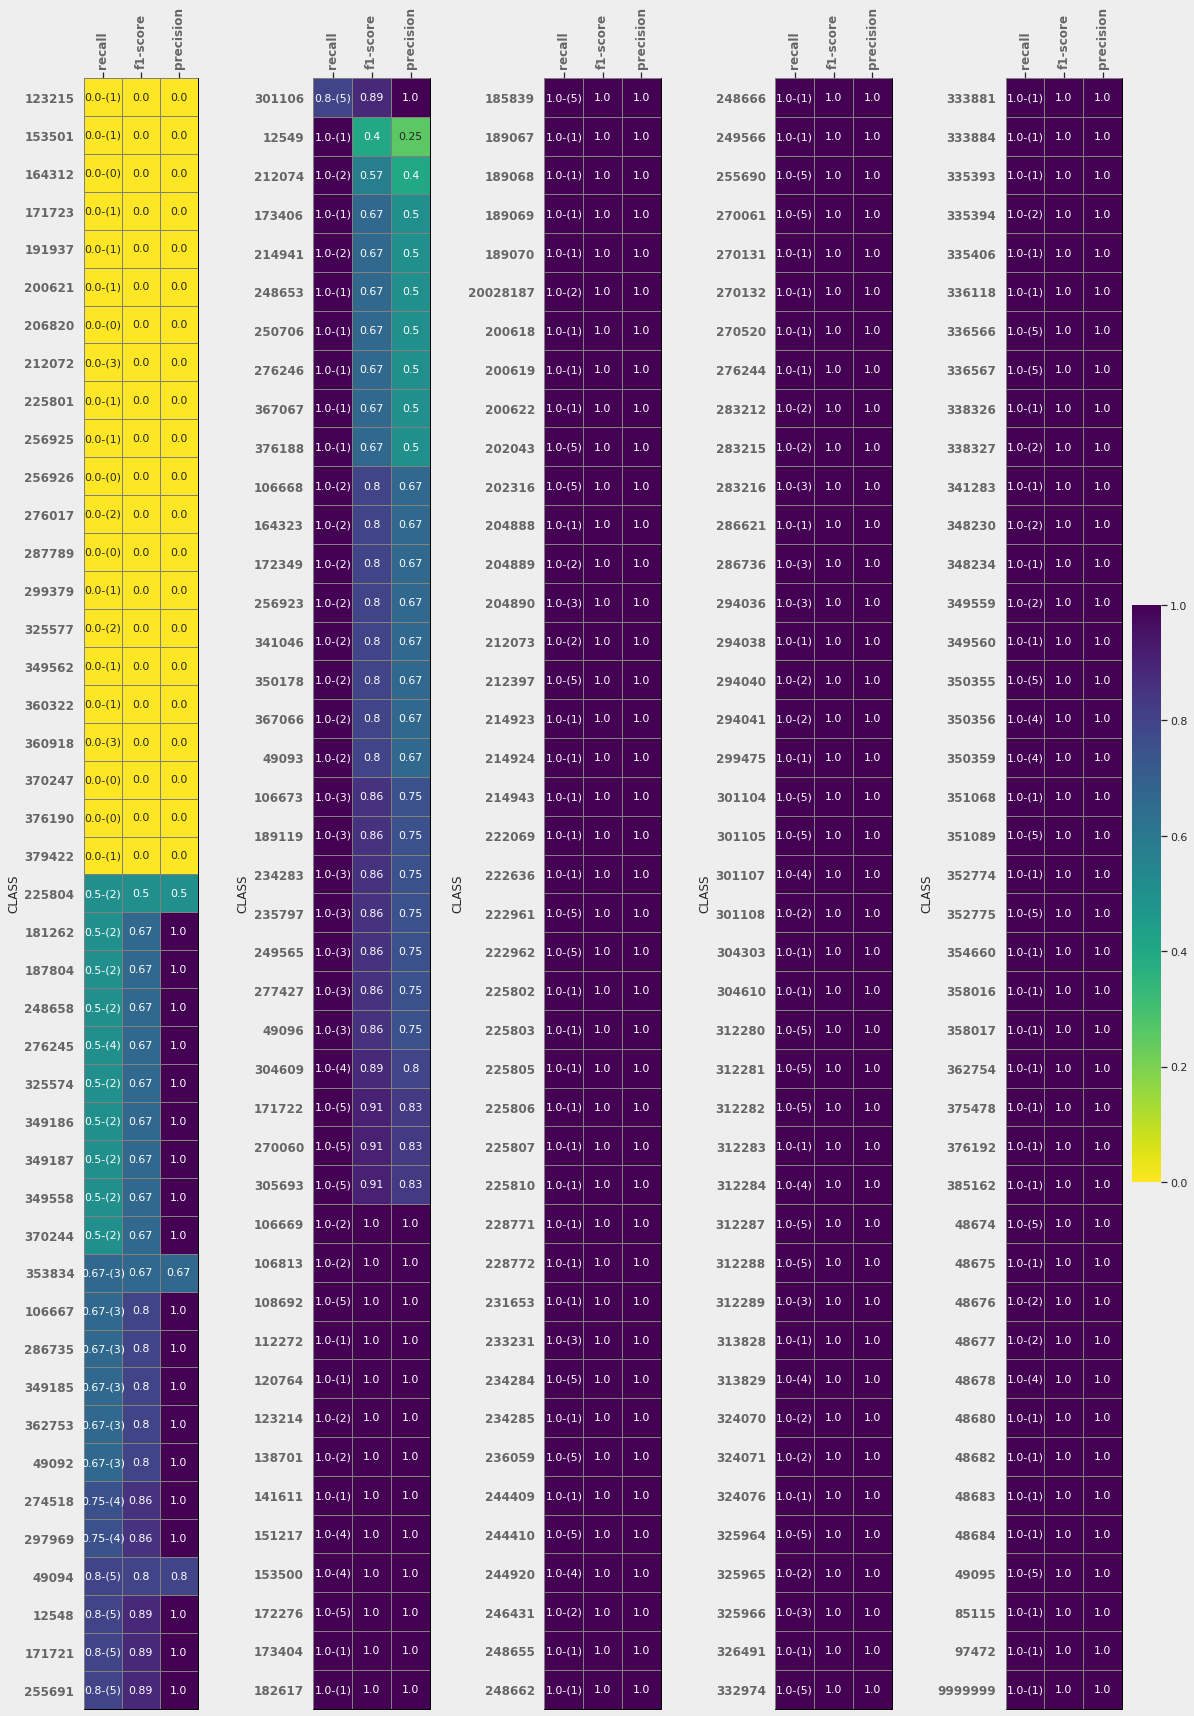

In [194]:
f, axes = plt.subplots(1,5,figsize=(20,30))

for i, (ax , part) in enumerate(zip(axes.flatten(), parts)):
    cbar = True if i==4 else False
    part = part.set_index('CLASS')
    annot = part.iloc[:,:-1].round(2).astype(str)
    annot['recall'] = annot['recall'] + '-('+ part['support'].astype(int).astype(str) +')'
    sns.heatmap(data = part.iloc[:,:-1],
                square=True,
                annot=annot,
                cbar=cbar,
                linewidths=.5,
#                 fmt=':.2d',
                ax =ax,
                vmax=1,
                vmin=0,
                annot_kws={'fontsize':11},
                cmap="viridis_r",
                linecolor='gray',
                fmt=''
               )
    ax.patch.set_edgecolor('black') 
    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=90,
                  fontsize = 12,
                     color='#666666',
                      fontweight = 'bold')
    ax.set_yticklabels(ax.get_yticklabels(),
                       rotation=0,
                      fontsize = 12,
                       color='#666666',
                      fontweight = 'bold')
    ax.xaxis.tick_top()
    ax.patch.set_linewidth('1')  

***

***

***

***

***

# api service 

In [6]:
from keras.preprocessing.image import img_to_array
import flask
from pathlib import Path
from tensorflow.keras.models import load_model
import io
from PIL import Image
import numpy as np
import pandas as pd 

app = flask.Flask(__name__)
product_classifier_model = None
product_detection_model = None


# product_detection

# product_classifier
BASE = Path('/workspace/detect-me/product_classifier/saved_models/by_category/')
model_path = list(Path(BASE / 'densenet121').glob('*231339'))[0]

def load_model_to_infer(model_path):
    global model
    model = load_model(model_path)

def get_train_info(model_path):
    csv = pd.read_csv(model_path/  'label_mapping.csv')
    train_count =\
        pd.read_csv(model_path / 'train_info.csv',
                              index_col=0,
                              names = ['code', 'count'])
    train_count = train_count.reset_index().dropna().drop('index',axis=1)

    joind_train_info = train_count.set_index('code').join(csv.set_index('CODE'))
    joind_train_info.index.name = 'label-code'
    joind_train_info = joind_train_info.reset_index()
    return joind_train_info

def prepare_image(image, target):
    # if the image mode is not RGB, convert it
    if image.mode != "RGB":
        image = image.convert("RGB")

    # resize the input image and preprocess it
    image = image.resize(target)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
#     image = imagenet_utils.preprocess_input(image)

    # return the processed image
    return image

def post_prediction(preds, info):
    return info[info['label-code'] == np.argmax(preds)]

@app.route("/predict", methods=["POST"])
def predict():
    # initialize the data dictionary that will be returned from the
    # view
#     data = {"success": False}

    # ensure an image was properly uploaded to our endpoint
    if flask.request.method == "POST":
        if flask.request.files.get("image"):
            # read the image in PIL format
            image = flask.request.files["image"].read()
            image = Image.open(io.BytesIO(image))

            # preprocess the image and prepare it for classification
            image = prepare_image(image, target=(224, 224))

            # classify the input image and then initialize the list
            # of predictions to return to the client
            preds = model.predict(image)
            info = get_train_info(model_path)
            
            result = post_prediction(preds, info)
            result = result.to_dict()
            result["success"] = True

    # return the data dictionary as a JSON response
    return flask.jsonify(result)

In [ ]:
# curl -X POST -F image=@NotCk_13195.jpg 'http://127.0.0.1:16006/predict'

In [7]:
if __name__ == "__main__":
    print(("* Loading Keras model and Flask starting server..."
        "please wait until server has fully started"))
    model_path = list(Path(BASE / 'densenet121').glob('*231339'))[0]
    load_model_to_infer(model_path)
    app.run(host='0.0.0.0', port=6666)

* Loading Keras model and Flask starting server...please wait until server has fully started
 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://172.17.0.2:6666/ (Press CTRL+C to quit)
172.17.0.2 - - [23/Aug/2021 11:06:44] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Aug/2021 11:15:04] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Aug/2021 11:15:08] "POST /predict HTTP/1.1" 200 -


---

---

---